In [1]:
import yaml
import matplotlib.pyplot as plt
from lvmsurveysim import IFU, Telescope
from lvmsurveysim.schedule import ObservingPlan, Simulator, TileDB
from lvmsurveysim.target import TargetList
from lvmsurveysim.target import Target
from astropy.io import fits
from astropy.wcs import WCS
from astropy.coordinates import SkyCoord
from astropy.visualization import PercentileInterval, SqrtStretch, ImageNormalize

In [2]:
with open('./smc.yaml', 'r') as f:
    tgt = yaml.safe_load(f)
tgt

{'SMC': {'coords': [13.1583, -72.8003],
  'region_type': 'ellipse',
  'frame': 'icrs',
  'region_params': {'a': 3.0, 'b': 1.78, 'pa': 45},
  'priority': 30,
  'observatory': 'LCO',
  'telescope': 'LVM-160',
  'max_airmass': 1.75,
  'min_shadowheight': 1.0,
  'exptime': 1200,
  'n_exposures': 9,
  'min_exposures': 3,
  'min_moon_dist': 45,
  'max_lunation': 0.25,
  'overhead': 1.1,
  'tiling_strategy': 'center_first',
  'tile_overlap': 0.0416,
  'group': ['MCs']}}

In [3]:
targets = TargetList(target_file='./smc.yaml')
print('Tiling Survey ...')
tiledb = TileDB(targets)
tiledb.tile_targets()
tiledb.tile_table.write('smc_tiles.fits', format='fits', overwrite=True)

Tiling Survey ...
Tiling target SMC


In [4]:
tbl = tiledb.tile_table
tbl

tile_id,target_index,target,telescope,ra,dec,pa,target_priority,tile_priority,airmass_limit,lunation_limit,hz_limit,moon_distance_limit,total_exptime,visit_exptime
int64,int64,str3,str7,float64,float64,float64,int64,int64,float64,float64,float64,int64,int64,int64
1000001,0,SMC,LVM-160,6.43766804734025,-75.16966993749213,6.424764439327347,30,1,1.75,0.25,1.0,45,10800,3600
1000002,0,SMC,LVM-160,9.280251465301177,-75.23404962535052,3.707811821762018,30,3,1.75,0.25,1.0,45,10800,3600
1000003,0,SMC,LVM-160,5.13637968718144,-74.91595632798729,7.666948160395025,30,1,1.75,0.25,1.0,45,10800,3600
1000004,0,SMC,LVM-160,7.927830407384575,-74.99638996382404,4.9998360163419715,30,3,1.75,0.25,1.0,45,10800,3600
1000005,0,SMC,LVM-160,10.742314468201258,-75.0428684358942,2.309672378710052,30,4,1.75,0.25,1.0,45,10800,3600
1000006,0,SMC,LVM-160,6.616853202343753,-74.7510726847016,6.251715823924972,30,3,1.75,0.25,1.0,45,10800,3600
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1000102,0,SMC,LVM-160,19.078776055802138,-70.95901606215567,354.3425364506529,30,2,1.75,0.25,1.0,45,10800,3600
1000103,0,SMC,LVM-160,13.47998523064438,-70.84344018318312,359.69252143825184,30,5,1.75,0.25,1.0,45,10800,3600


In [5]:
ifu = IFU.from_config()
lvm160 = Telescope.from_config('LVM-160')

In [6]:
lvm160.plate_scale

<Quantity 348.42060811 arcsec / mm>

In [7]:
# Load SHASSA image
dat, hdr = fits.getdata('010.fl.fits.gz', header=True)
wcs = WCS(hdr)
print(dat.shape)

(998, 1014)


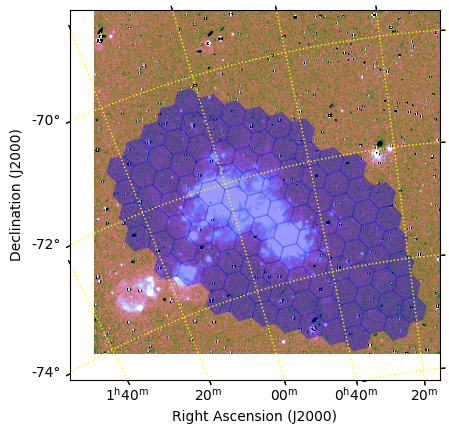

In [8]:
fig = plt.figure()
ax = fig.add_subplot(projection=wcs)
norm = ImageNormalize(dat, interval=PercentileInterval(98),
                      stretch=SqrtStretch())
ax.imshow(dat, origin='lower', cmap='cubehelix', norm=norm)
ax.coords[0].set_axislabel('Right Ascension (J2000)')
ax.coords[1].set_axislabel('Declination (J2000)')
ax.grid(color='yellow', ls=':', lw=1)
ax.set_xlim(0, 500)
ax.set_ylim(0, 500)
for p in tbl:
    patch = ifu.get_patch(scale=lvm160.plate_scale, centre=[p['ra'], p['dec']], pa=p['pa'],
                            edgecolor='None', linewidth=0.0, alpha=0.4, facecolor='b',
                            transform=ax.get_transform('fk5'))[0]
    ax.add_patch(patch)

In [9]:
smc = Target.from_list('SMC',targets=tgt)
smc

<Target (name='SMC', telescope='LVM-160', region_type='ellipse')>

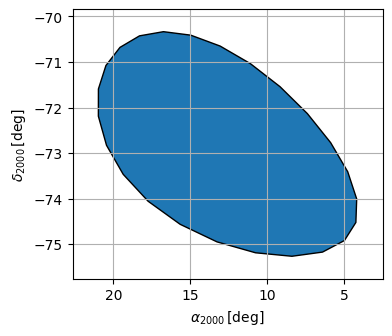

In [10]:
fig,ax=smc.plot()
fig.set_figheight(3.5)
fig.set_figwidth(4)
ax.invert_xaxis()